In [ ]:
import pandas as pd
df = pd.read_csv("elon_musk_timeline.csv", dayfirst=True)
df

,Date,Event,Category,Description,Source
0,12-11-2015,OpenAI announced,Business/Tech,OpenAI publicly announced as nonprofit AI lab.,https://openai.com/index/introducing-openai/
1,10-14-2015,Tesla Autopilot v1 released,Business/Tech,Tesla rolls out first Autopilot features to cu...,https://www.tesla.com/blog
2,03-31-2016,Tesla Model 3 unveiled,Business,Model 3 reveal; hundreds of thousands of reser...,https://abcnews.go.com/Technology/tesla-model-...
3,06-21-2016,Neuralink incorporated,Business/Tech,Neuralink founded (incorporation date).,https://en.wikipedia.org/wiki/Neuralink
4,08-01-2016,SolarCity accepts Tesla offer,Business,SolarCity board accepts Tesla’s acquisition of...,https://www.reuters.com/article/business/solar...
5,11-17-2016,Tesla closes SolarCity acquisition,Business,Tesla completes ~$2B acquisition of SolarCity.,https://www.reuters.com/article/business/tesla...
6,12-17-2016,The Boring Company founded,Business/Infrastructure,Musk starts tunnel venture The Boring Company.,https://en.wikipedia.org/wiki/The_Boring_Company
7,07-28-2017,First Model 3 deliveries,Business,Tesla hands over first 30 Model 3 cars.,https://www.reuters.com/article/business/tesla...
8,11-16-2017,Tesla Semi & new Roadster unveiled,Business,Tesla debuts electric semi-truck and next-gen ...,https://www.reuters.com
9,02-06-2018,Falcon Heavy maiden flight,Business/Space,First Falcon Heavy launch; Tesla Roadster as d...,https://www.nasa.gov/history/5-years-ago-first...


Loaded 44 events from 2015-10-14 to 2025-10-13.


/tmp/ipython-input-3603932482.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tsla_df = yf.download("TSLA", start=START, end=END, progress=False)
/tmp/ipython-input-3603932482.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla["ret"] = np.log(tsla["Close"]).diff()


44 total event weeks identified.


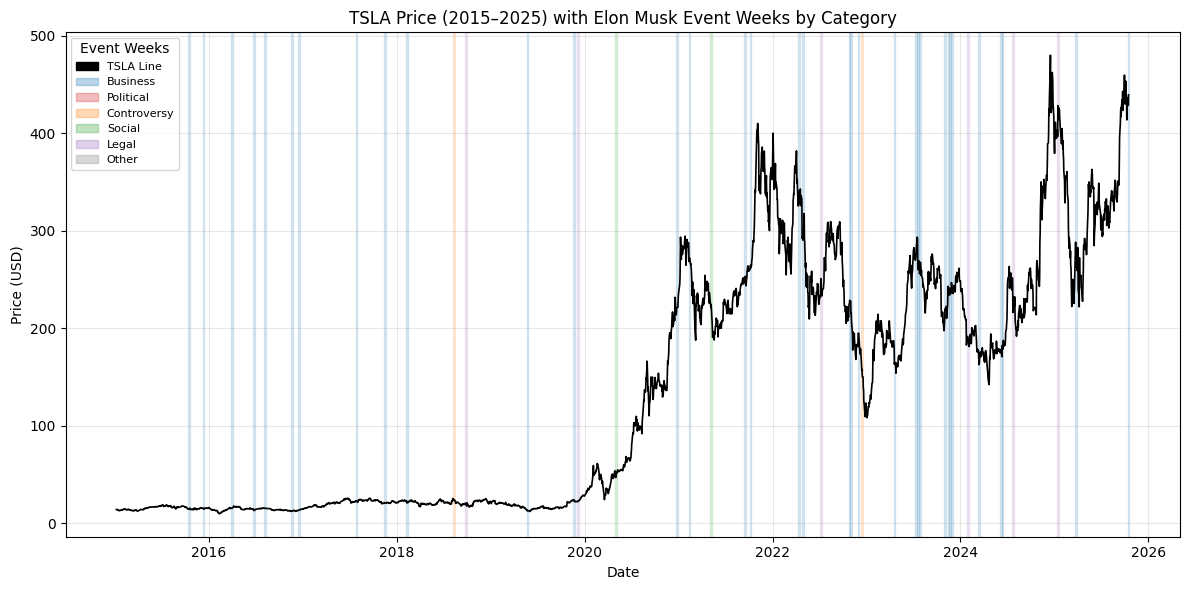

In [ ]:
# Elon Musk Events vs TSLA Timeline (Boolean + Weekly Shading)
# ------------------------------------------------------------

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.patches import Patch

# ---------------- USER SETTINGS ----------------
START = "2015-01-01"
END   = "2025-10-20"     # <- YYYY-MM-DD format for yfinance
EVENTS_CSV = "elon_musk_timeline.csv"   # your file (mm-dd-yyyy)
# ------------------------------------------------

# ---- 1. Load Events ----
events = pd.read_csv(EVENTS_CSV)

# Convert mm-dd-yyyy → datetime
events["date"] = pd.to_datetime(events["Date"], format="%m-%d-%Y", errors="coerce")
events = events.dropna(subset=["date"])

# Filter within range
events = events[(events["date"] >= pd.to_datetime(START)) & (events["date"] <= pd.to_datetime(END))]

# If Category column missing, fill with "Other"
if "Category" not in events.columns:
    events["Category"] = "Other"

print(f"Loaded {len(events)} events from {events['date'].min().date()} to {events['date'].max().date()}.")

# ---- 2. Download TSLA Data ----
print("Downloading TSLA data from Yahoo Finance...")
tsla_df = yf.download("TSLA", start=START, end=END, progress=False)

# Use adjusted close if available
if "Adj Close" in tsla_df.columns:
    tsla = tsla_df[["Adj Close"]].rename(columns={"Adj Close": "Close"})
elif "Close" in tsla_df.columns:
    tsla = tsla_df[["Close"]]
else:
    raise ValueError("No 'Close' or 'Adj Close' column found in Yahoo data.")

# Compute daily returns
tsla["ret"] = np.log(tsla["Close"]).diff()
tsla = tsla.dropna()
tsla["week"] = tsla.index.to_period("W").start_time

# ---- 3. Clean Categories & Weekly Boolean ----
# Simplify combined categories ("Business/Legal" → "Business")
events["MainCategory"] = events["Category"].apply(lambda x: str(x).split("/")[0].strip())
events["week"] = events["date"].dt.to_period("W").dt.start_time

# Aggregate to weekly event dummy
weekly = tsla.groupby("week", as_index=False)["ret"].sum().rename(columns={"ret": "ret_tsla_w"})
weekly_ev = events.groupby(["week", "MainCategory"], as_index=False).size()
weekly_ev["event_dummy"] = 1

weekly = weekly.merge(weekly_ev[["week", "event_dummy"]].drop_duplicates(), on="week", how="left")
weekly["event_dummy"] = weekly["event_dummy"].fillna(0).astype(int)

print(f"{weekly['event_dummy'].sum()} total event weeks identified.")

# ---- 4. Plot: TSLA with Shaded Event Weeks ----
colors = {
    "Business": "tab:blue",
    "Political": "tab:red",
    "Controversy": "tab:orange",
    "Social": "tab:green",
    "Legal": "tab:purple",
    "Other": "gray"
}

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tsla.index, tsla["Close"], color="black", linewidth=1.2, label="TSLA")

# Shade event weeks by category
for cat, grp in events.groupby("MainCategory"):
    for w in grp["week"].unique():
        start = pd.Timestamp(w)
        end = start + pd.Timedelta(days=7)
        ax.axvspan(start, end, color=colors.get(cat, "gray"), alpha=0.15)

# Titles & labels
ax.set_title("TSLA Price (2015–2025) with Elon Musk Event Weeks by Category")
ax.set_ylabel("Price (USD)")
ax.set_xlabel("Date")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# Legend patches
legend_patches = [Patch(color="black", label="TSLA Line")]
legend_patches += [Patch(color=c, alpha=0.3, label=k) for k, c in colors.items()]
ax.legend(handles=legend_patches, title="Event Weeks", fontsize=8)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
